# Import Necessary Packages

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

# Set Random Seeds for Reproducibility

In [2]:
# Set global seeds for reproducibility
np.random.seed(99)
random.seed(99)

# Load & Understand Data (Section 2.1)

In [3]:
# Load data into pandas dataframe
df = pd.read_csv('obp.csv')

In [4]:
# Display first few rows to understand dataframe
df.head()

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,0.162,55.0,0.218,262.0,0.302
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315
4,Nick Fortes,21538,1996-11-11,34,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check columns for null values
# df.isnull().sum()

In [6]:
# Use the describe method to get high level understanding of data
# df.describe()

# Visualize Data (Section 2.2)

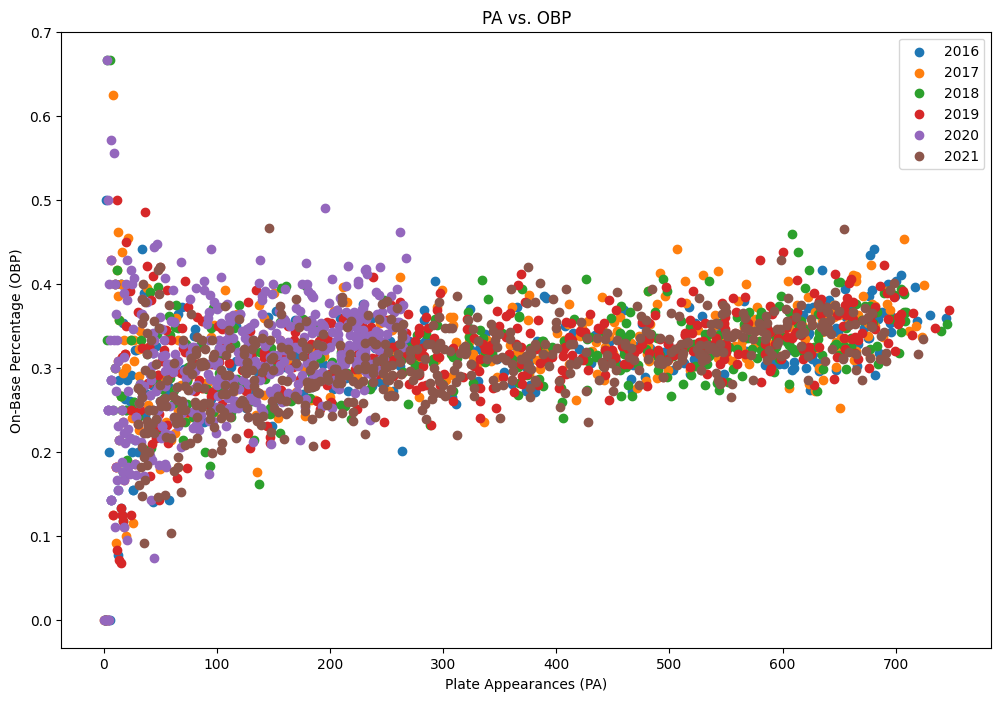

In [7]:
# Produce scatter plot to visualize the relationship between Plate Appearances (PA) and On-Base Percentage (OBP) for each year
years = ['16', '17', '18', '19', '20', '21']
# Create figure object and set figure size
plt.figure(figsize = (12,8))
for year in years:
    plt.scatter(df[f'PA_{year}'], df[f'OBP_{year}'], label=f'20{year}')
# Add title, legend and x, y labels
plt.xlabel('Plate Appearances (PA)')
plt.ylabel('On-Base Percentage (OBP)')
plt.title('PA vs. OBP')
plt.legend()
plt.show()

# Data Preprocessing (Section 2.3)

In [8]:
# Remove players with insufficient plate appearances (e.g., less than 100 in total)
df = df[df[['PA_16', 'PA_17', 'PA_18', 'PA_19', 'PA_20']].sum(axis=1) >= 100]

# Handle any missing values by filling with the median
years = ['16', '17', '18', '19', '20', '21']
for year in years:
    df[f'OBP_{year}'] = df[f'OBP_{year}'].fillna(df[f'OBP_{year}'].median())
    df[f'PA_{year}'] = df[f'PA_{year}'].fillna(df[f'PA_{year}'].median())

# Convert birth date to age in 2021
df['age'] = 2021 - pd.to_datetime(df['birth_date']).dt.year

# Feature Analysis (Section 2.4)

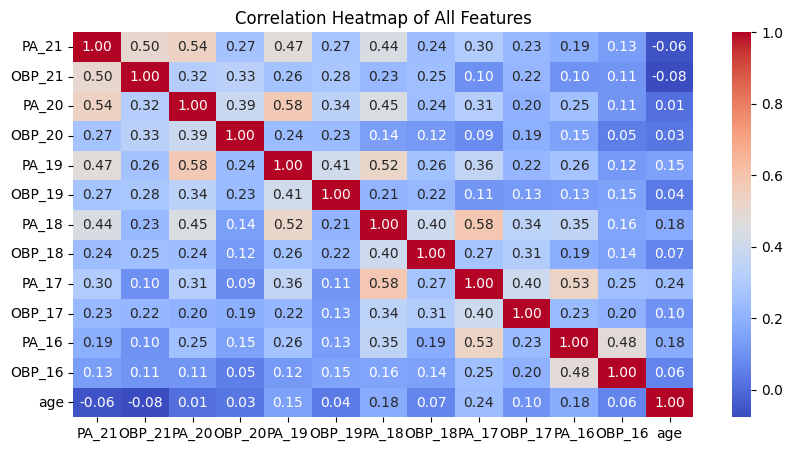

In [9]:
# Isolate features and target columns
data_cols = ['PA_21', 'OBP_21', 'PA_20', 'OBP_20', 'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16', 'OBP_16', 'age']

# Create figure object
plt.figure(figsize=(10, 5))
# Create correlation matrix using features
correlation_matrix = df[data_cols].corr()
# Create Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# Add title
plt.title('Correlation Heatmap of All Features')
plt.show()

# Feature Engineering (Section 2.4)

In [10]:
# Create a weighted OBP feature from other columns giving more weight to OBP from recent years
df['OBP_weighted'] = (df['OBP_16'] * 0.1 + df['OBP_17'] * 0.15 
                      + df['OBP_18'] * 0.2 + df['OBP_19'] * 0.25 
                      + df['OBP_20'] * 0.3)

# Create OBP trend features from other columns to account for how the OBP is moving year to year
df['OBP_trend_1920'] = df['OBP_20'] - df['OBP_19']
df['OBP_trend_1819'] = df['OBP_19'] - df['OBP_18']

# Split Data into Training and Testing Sets (Section 2.5)

In [11]:
# Define features and target variable
features = ['PA_20', 'OBP_20', 'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16', 'OBP_16',
            'age', 'OBP_weighted', 'OBP_trend_1920', 'OBP_trend_1819']
target = 'OBP_21'

# Split data into training and testing sets (reproducible results)
x_train, x_test, y_train, y_test = train_test_split(df[features], df[target], train_size = 0.7, test_size = 0.3, random_state=99)

# Training Models (Section 2.5)

In [12]:
# Gather a list of models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest Regression': RandomForestRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'ElasticNet Regression': ElasticNet(),
}

# Train each model using training data
for model in models.values():
    model.fit(x_train, y_train)

# Model Evaluation (Section 2.6)

In [13]:
# Define a function to evaluate model prediction accuracy
def evaluate_model(model, x_test, y_test):
    # Make predictions using test set
    predictions = model.predict(x_test)
    # Calculate the Mean Squared Error using test set and predictions
    mse = mean_squared_error(y_test, predictions)
    # Calculate the Coefficient of Determination using test set and predictions
    r2 = r2_score(y_test, predictions)
    print(f'MSE: {mse:.4f} and R2: {r2:.4f}')

# Evaluate each model
for name, model in models.items():
    print(f'Evaluating {name}:')
    evaluate_model(model, x_test, y_test)

Evaluating Linear Regression:
MSE: 0.0018 and R2: 0.1411
Evaluating Ridge Regression:
MSE: 0.0018 and R2: 0.1556
Evaluating Lasso Regression:
MSE: 0.0019 and R2: 0.0716
Evaluating Random Forest Regression:
MSE: 0.0020 and R2: 0.0678
Evaluating Decision Tree Regressor:
MSE: 0.0037 and R2: -0.7820
Evaluating Gradient Boosting:
MSE: 0.0019 and R2: 0.0937
Evaluating AdaBoost:
MSE: 0.0020 and R2: 0.0289
Evaluating ElasticNet Regression:
MSE: 0.0019 and R2: 0.1063


# Make Predictions using Best Models (Appendix A)

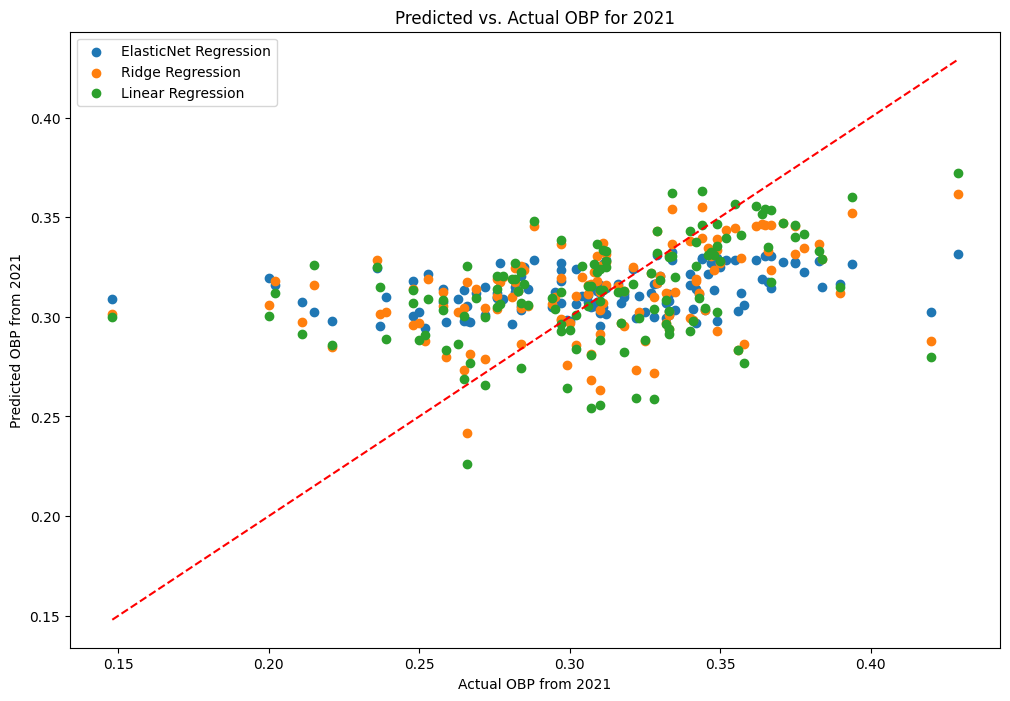

In [14]:
# Choose best models
best_models = ['ElasticNet Regression', 'Ridge Regression', 'Linear Regression']

# Create Figure Object
plt.figure(figsize = (12, 8))
# Loop through each model and add predictions to the plot
for i in range(len(best_models)):
    # Select model
    model = models[best_models[i]]
    # Make predictions based on test set
    predictions = model.predict(x_test)
    # Add points to scatter plot
    plt.scatter(y_test, predictions, label = f'{best_models[i]}')

# Add hypothetical perfect prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# Add title, legend and x, y labels
plt.xlabel('Actual OBP from 2021')
plt.ylabel('Predicted OBP from 2021')
plt.title('Predicted vs. Actual OBP for 2021')
plt.legend()
plt.show()

# Feature Selection (Section 2.7)

In [15]:
# Select Ridge Regression model
model = models['Ridge Regression']

# Get the coefficients from the trained model
coefficients = model.coef_

# Create a dataframe to display feature importance. 
# *** Calculate the absolute value of the coefficients to capture significant negative 
# correlations (ie increased age has a strong, negative correlation with OBP) ***
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': [round(abs(c),6) for c in coefficients]
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

           Feature  Importance
1           OBP_20    0.086292
11    OBP_weighted    0.057276
3           OBP_19    0.057047
5           OBP_18    0.046819
7           OBP_17    0.043048
12  OBP_trend_1920    0.029245
9           OBP_16    0.013060
13  OBP_trend_1819    0.010228
10             age    0.001556
0            PA_20    0.000109
4            PA_18    0.000034
6            PA_17    0.000025
2            PA_19    0.000011
8            PA_16    0.000001


In [16]:
# Initialize Recursive Feature Elimination (RFE) with the model and the top 10 features
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit RFE
rfe.fit(x_train, y_train)

# Get the selected features
selected_features = x_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Define target variable
target = 'OBP_21'

# Split data into training and testing subsets (reproducible results)
x_train, x_test, y_train, y_test = train_test_split(df[selected_features], df[target], train_size = 0.7, test_size = 0.3, random_state=99)

Selected Features: Index(['PA_20', 'OBP_20', 'OBP_19', 'OBP_18', 'OBP_17', 'OBP_16', 'age',
       'OBP_weighted', 'OBP_trend_1920', 'OBP_trend_1819'],
      dtype='object')


# Hyperparameter Tuning (Section 2.7)

In [17]:
# Grab new Ridge model
ridge = Ridge()

# Define a space to choose an optimal value for alpha
param_grid = {'alpha': np.logspace(-4, 4, 50)}

# Use cross-validation to determine the optimal value for alpha (tries many values to find best fit)
# Scoring is based on the negative mean squared error
ridge = GridSearchCV(estimator = ridge, param_grid = param_grid, scoring = 'neg_mean_squared_error')

# Fit the model to the training data
ridge.fit(x_train, y_train)

# Best alpha for Ridge Regression
print(f"Best alpha for Ridge Regression: {ridge.best_params_['alpha']}")

Best alpha for Ridge Regression: 0.3906939937054613


In [18]:
# Create a new model with the optimal value for alpha
best_ridge_model = Ridge(alpha = ridge.best_params_['alpha'])

# Fit the new, hyperparameter tuned model to the training data
best_ridge_model.fit(x_train, y_train)

# Evaluate the model
evaluate_model(best_ridge_model, x_test, y_test)

MSE: 0.0018 and R2: 0.1568


# Find Players with the Largest Prediction Errors (Appendix B)

In [19]:
# Select model
model = best_ridge_model

# Make predictions based on test set
predictions = model.predict(x_test)

# Calculate the absolute difference between the test set and the model's predictions
errors = abs(y_test - predictions)

# Create dataframe to compare errors
error_df = pd.DataFrame({'Player': df.loc[x_test.index, 'Name'], 'Actual': np.round(y_test,3), 'Predicted': np.round(predictions,3), 'Error': np.round(errors,3)})

# Print the top 5 errors
print(error_df.sort_values(by='Error', ascending=False).head())

                Player  Actual  Predicted  Error
565  Albert Almora Jr.   0.148      0.292  0.144
3         Chris Owings   0.420      0.284  0.136
545         Evan White   0.202      0.317  0.115
560       Todd Frazier   0.200      0.306  0.106
547       Andrew Knapp   0.215      0.321  0.106
